In [4]:
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score, multilabel_confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
import librosa
import librosa.display
import librosa.feature
import IPython.display as ipd

In [5]:
x = np.load('../Part1.npy')
Y_t = np.load('../train.npy/y_train.npy')
#X_train = (x-np.min(x))/(np.max(x)-np.min(x))
xt = np.load('../Part2.npy')
Y_test = np.load('../test.npy/Y_Test.npy')
#X_test = (xt-np.min(xt))/(np.max(xt)-np.min(xt))
x_add = np.load('../Part3.npy')
y_add = np.load('../additional.npy/Y_additional.npy')
#x_add = (x_add-np.min(x_add))/(np.max(x_add)-np.min(x_add))
Y_train = np.concatenate((Y_t, Y_test, y_add))
X_train = np.concatenate((x, xt, x_add))
#X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [6]:
X_train.shape

(2874, 17)

In [7]:
#IRMAS-TrainingData/cel/[cel][pop_roc]0143__3.wav
instruments = ['cel/','cla/','flu/','gac/','gel/','org/','pia/','sax/','tru/','vio/','voi/']
pathAudio = "../IRMAS-TrainingData/"
X_test = []
Y_test = []
cnt = 0
for i in instruments:
    label = np.zeros(11)
    label[cnt] = 1
    cnt +=1
    #print(pathAudio + i)
    files = librosa.util.find_files(pathAudio + i, ext=['wav'], recurse=False) 
    files = np.asarray(files)
    #print(files)
    for y in files:
        #print(test)
        y, sr = librosa.load(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff = np.mean(rolloff)
        bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        bw = np.mean(bw)
        ctr = librosa.feature.spectral_centroid(y=y, sr=sr)
        ctr = np.mean(ctr)
        zcr = librosa.feature.zero_crossing_rate(y=y)
        zcr = np.mean(zcr)
        mfcc = np.mean(mfcc, axis=1)
        mfcc = mfcc[:13]
        mfcc = np.append(mfcc, [rolloff, bw, ctr, zcr])
        X_test.append(mfcc)
        Y_test.append(label)

In [8]:
X_test = np.load('X_single.npy')
Y_test = np.load('Y_single.npy')
scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [9]:
np.array(X_test).shape

(6705, 17)

In [10]:
mlp = MLPClassifier(activation = 'identity',hidden_layer_sizes = [100] ,solver = 'lbfgs',alpha = 0.00003, batch_size = 50,
                    learning_rate_init=0.058, max_iter = 114, warm_start=True)
chains = [ClassifierChain(mlp, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

In [11]:
Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)

In [12]:
chain_jaccard_scores

[0.1303504847129008,
 0.11792194879443203,
 0.12321650509569972,
 0.1317424807357693,
 0.12033308476261495,
 0.12652249565001242,
 0.15264727815063386,
 0.1177728063634104,
 0.16644295302013423,
 0.13646532438478748]

In [13]:
Y_pred = np.where(Y_pred_ensemble>0.5,1,0)

In [14]:
Y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [15]:
m = multilabel_confusion_matrix(Y_test, Y_pred)

In [16]:
m

array([[[6300,   17],
        [ 388,    0]],

       [[6195,    5],
        [ 501,    4]],

       [[6253,    1],
        [ 451,    0]],

       [[5840,  228],
        [ 547,   90]],

       [[5421,  524],
        [ 586,  174]],

       [[6017,    6],
        [ 682,    0]],

       [[2553, 3431],
        [ 322,  399]],

       [[6032,   47],
        [ 625,    1]],

       [[6122,    6],
        [ 572,    5]],

       [[6039,   86],
        [ 573,    7]],

       [[4833, 1094],
        [ 634,  144]]])

In [17]:
precision = [x[1,1]/(x[1,1]+x[0,1]) for x in m]

In [18]:
precision

[0.0,
 0.4444444444444444,
 0.0,
 0.2830188679245283,
 0.2492836676217765,
 0.0,
 0.104177545691906,
 0.020833333333333332,
 0.45454545454545453,
 0.07526881720430108,
 0.11631663974151858]

In [19]:
recall = np.array([x[1,1]/(x[1,1]+x[1,0]) for x in m])


In [20]:
recall

array([0.        , 0.00792079, 0.        , 0.14128728, 0.22894737,
       0.        , 0.55339806, 0.00159744, 0.00866551, 0.01206897,
       0.18508997])

In [21]:
f1 = 2*(precision*recall/(precision+recall))
f1

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_61378/145254599.py:1: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2*(precision*recall/(precision+recall))


array([       nan, 0.0155642 ,        nan, 0.18848168, 0.23868313,
              nan, 0.17534608, 0.00296736, 0.0170068 , 0.02080238,
       0.14285714])

In [22]:
ovr = OneVsRestClassifier(mlp)
ovr.fit(X_train, Y_train)

OneVsRestClassifier(estimator=MLPClassifier(activation='identity', alpha=3e-05,
                                            batch_size=50,
                                            hidden_layer_sizes=[100],
                                            learning_rate_init=0.058,
                                            max_iter=114, solver='lbfgs',
                                            warm_start=True))

In [23]:
ovr_pred = ovr.predict(X_test)
M_ovr = multilabel_confusion_matrix(Y_test, ovr_pred)
M_ovr

array([[[6312,    5],
        [ 388,    0]],

       [[6197,    3],
        [ 500,    5]],

       [[6253,    1],
        [ 451,    0]],

       [[6048,   20],
        [ 621,   16]],

       [[5549,  396],
        [ 625,  135]],

       [[6015,    8],
        [ 682,    0]],

       [[5426,  558],
        [ 616,  105]],

       [[6063,   16],
        [ 626,    0]],

       [[6121,    7],
        [ 572,    5]],

       [[6082,   43],
        [ 578,    2]],

       [[5365,  562],
        [ 716,   62]]])

In [24]:
p, r, f1, s = precision_recall_fscore_support(Y_test, ovr_pred)

In [25]:
p

array([0.        , 0.625     , 0.        , 0.44444444, 0.25423729,
       0.        , 0.15837104, 0.        , 0.41666667, 0.04444444,
       0.09935897])

In [26]:
r

array([0.        , 0.00990099, 0.        , 0.02511774, 0.17763158,
       0.        , 0.14563107, 0.        , 0.00866551, 0.00344828,
       0.07969152])

In [27]:
f1

array([0.        , 0.01949318, 0.        , 0.04754829, 0.2091402 ,
       0.        , 0.1517341 , 0.        , 0.01697793, 0.0064    ,
       0.08844508])

In [28]:
s

array([388, 505, 451, 637, 760, 682, 721, 626, 577, 580, 778])

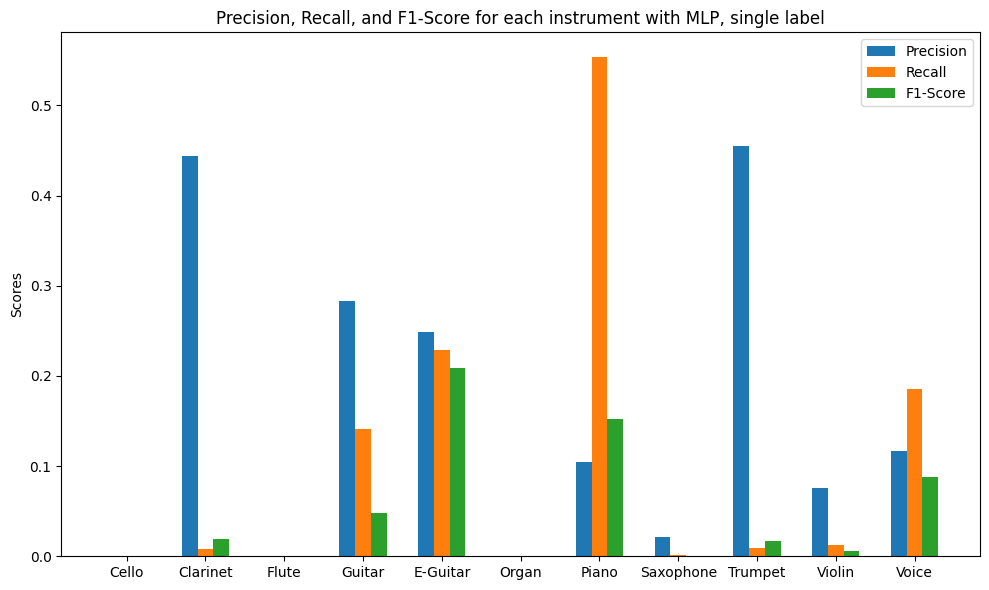

In [29]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
x_ax = ["Cello","Clarinet", "Flute", "Guitar", "E-Guitar", "Organ", "Piano", "Saxophone", "Trumpet", "Violin", "Voice"]
x = np.arange(len(precision))  # the label locations
width = 0.2  # the width of the bars
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for each instrument with MLP, single label')
ax.set_xticks(x)
ax.set_xticklabels([i for i in x_ax])
ax.legend()
fig.tight_layout()
plt.savefig('ScoresMLPsingle.png')
plt.show()